In [32]:
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt 
import os 
import json
from collections import Counter 

# Import Dataset

In [33]:
init_path = "../../data/"
train_data = pd.read_csv(init_path + "train_data.csv")
test_data = pd.read_csv(init_path + "test_data.csv")
val_data = pd.read_csv(init_path + "val_data.csv")

In [34]:
def extract_data(data):
    X = data["Source"]
    y = data["Label"]
    return np.asarray(X), np.asarray(y)

X_train, y_train = extract_data(train_data)
y_train = y_train-1
X_test, y_test = extract_data(test_data)
y_test = y_test-1
X_val, y_val = extract_data(val_data)
y_val = y_val-1

In [17]:
print("Train labels ratio: ")
print(Counter(y_train.tolist()))

print("Test labels ratio: ")
print(Counter(y_test.tolist()))

print("Val labels ratio: ")
print(Counter(y_val.tolist()))

Train labels ratio: 
Counter({2: 12586, 1: 3298, 0: 152})
Test labels ratio: 
Counter({2: 2700, 1: 727, 0: 33})
Val labels ratio: 
Counter({2: 2725, 1: 702, 0: 32})


# Training and Testing

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

max_sequence_length = 100 # Due to memory constraints we are just taking first 100 words for evaluating its fluency

sequences_padded_train = pad_sequences(sequences_train, maxlen=max_sequence_length, padding='post')
sequences_padded_test = pad_sequences(sequences_test, maxlen=max_sequence_length, padding='post')
sequences_padded_val = pad_sequences(sequences_val, maxlen=max_sequence_length, padding='post')

In [22]:
embedding_dim = 50
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size (+1 for padding token)
lstm_units = 32 # number of hidden units within an LSTM layer

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(units=lstm_units)))
model.add(Dense(units=3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
model.fit(sequences_padded_train, np.array(y_train), epochs=5, batch_size=1, validation_data=(sequences_padded_val, np.array(y_val)), verbose=1)

Epoch 1/5
16036/16036 [==============================] - 326s 20ms/step - loss: 0.5660 - accuracy: 0.7846 - val_loss: 0.5572 - val_accuracy: 0.7878
Epoch 2/5
16036/16036 [==============================] - 330s 21ms/step - loss: 0.5372 - accuracy: 0.7858 - val_loss: 0.5735 - val_accuracy: 0.7864
Epoch 3/5
16036/16036 [==============================] - 331s 21ms/step - loss: 0.4987 - accuracy: 0.7933 - val_loss: 0.5822 - val_accuracy: 0.7777
Epoch 4/5
16036/16036 [==============================] - 351s 22ms/step - loss: 0.4684 - accuracy: 0.7978 - val_loss: 0.6437 - val_accuracy: 0.7679
Epoch 5/5
16036/16036 [==============================] - 325s 20ms/step - loss: 0.4458 - accuracy: 0.8021 - val_loss: 0.6817 - val_accuracy: 0.7534


In [30]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

def get_metrics(ytrue, ypred, _type):
    print(classification_report(ytrue, ypred, zero_division=1))
    ret = classification_report(ytrue, ypred, output_dict=True, zero_division=1)
    ConfusionMatrixDisplay.from_predictions(ytrue, ypred)
    plt.savefig(os.path.join(results_dir, f"confusion_{_type}.png"), dpi=300)
    plt.show()
    print('\n\n')
    with open(os.path.join(results_dir, f"stats_{_type}.json"), "w") as f:
        json.dump(ret, f, indent=4)

On Train: 
502/502 [==============================] - 3s 5ms/step
              precision    recall  f1-score   support

           0       1.00      0.01      0.01       152
           1       0.74      0.23      0.36      3298
           2       0.82      0.98      0.89     12586

    accuracy                           0.82     16036
   macro avg       0.85      0.41      0.42     16036
weighted avg       0.81      0.82      0.78     16036



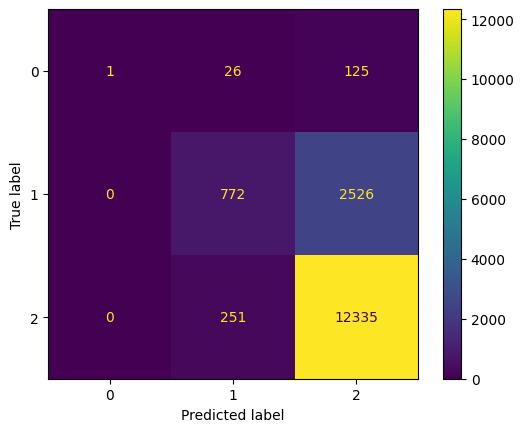




On Val: 
109/109 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        32
           1       0.28      0.11      0.16       702
           2       0.80      0.93      0.86      2725

    accuracy                           0.75      3459
   macro avg       0.69      0.35      0.34      3459
weighted avg       0.69      0.75      0.71      3459



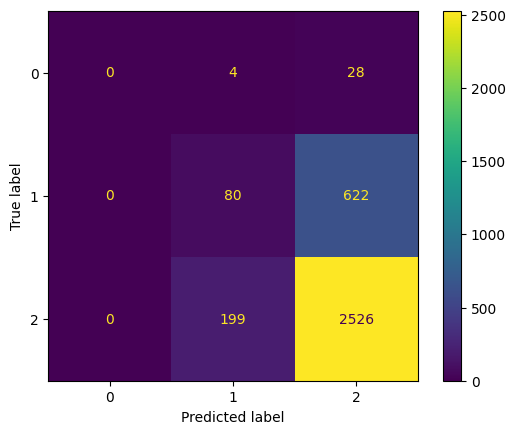




On Test: 
109/109 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        33
           1       0.24      0.09      0.13       727
           2       0.78      0.93      0.85      2700

    accuracy                           0.74      3460
   macro avg       0.67      0.34      0.33      3460
weighted avg       0.67      0.74      0.69      3460



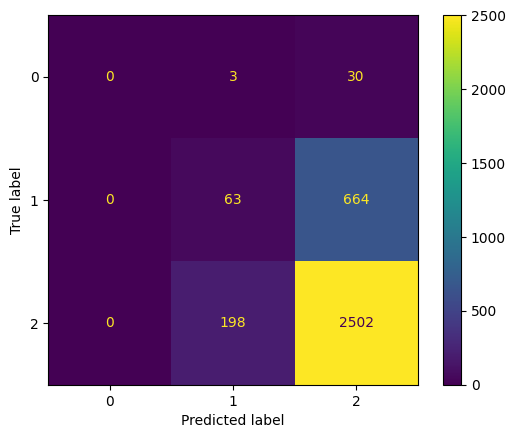

In [31]:
print("On Train: ")
y_pred_probabilities = model.predict(sequences_padded_train)
y_pred = np.argmax(y_pred_probabilities, axis=1)
get_metrics(y_train, y_pred, "train")

print("On Val: ")
y_pred_probabilities = model.predict(sequences_padded_val)
y_pred = np.argmax(y_pred_probabilities, axis=1)
get_metrics(y_val, y_pred, "val")

print("On Test: ")
y_pred_probabilities = model.predict(sequences_padded_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)
get_metrics(y_test, y_pred, "test")


### Now we can see still the results turn out to be not satisfying for class 1, 2. So we again use the same technique "class weights"  - which assigns higher weights to minority classes during model training to give them more importance , which we saw in logistic regression. 

In [37]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train) , y=y_train)
class_weights

array([35.16666667,  1.62078027,  0.4247047 ])

In [39]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model2.add(Bidirectional(LSTM(units=lstm_units)))
model2.add(Dense(units=3, activation='softmax'))
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.fit(sequences_padded_train, np.array(y_train), epochs=5, batch_size=1, validation_data=(sequences_padded_val, np.array(y_val)), verbose=1)

Epoch 1/5
16036/16036 [==============================] - 327s 20ms/step - loss: 0.5649 - accuracy: 0.7849 - val_loss: 0.5768 - val_accuracy: 0.7878
Epoch 2/5
16036/16036 [==============================] - 325s 20ms/step - loss: 0.5400 - accuracy: 0.7845 - val_loss: 0.5817 - val_accuracy: 0.7823
Epoch 3/5
16036/16036 [==============================] - 325s 20ms/step - loss: 0.4967 - accuracy: 0.7918 - val_loss: 0.5946 - val_accuracy: 0.7681
Epoch 4/5
16036/16036 [==============================] - 325s 20ms/step - loss: 0.4657 - accuracy: 0.7993 - val_loss: 0.6317 - val_accuracy: 0.7404
Epoch 5/5
16036/16036 [==============================] - 328s 20ms/step - loss: 0.4447 - accuracy: 0.8029 - val_loss: 0.7105 - val_accuracy: 0.7389


In [40]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

def get_metrics2(ytrue, ypred, _type):
    print(classification_report(ytrue, ypred, zero_division=1))
    ret = classification_report(ytrue, ypred, output_dict=True, zero_division=1)
    ConfusionMatrixDisplay.from_predictions(ytrue, ypred)
    plt.savefig(os.path.join(results_dir, f"confusion_ClassWeight_{_type}.png"), dpi=300)
    plt.show()
    print('\n\n')
    with open(os.path.join(results_dir, f"stats_ClassWeight_{_type}.json"), "w") as f:
        json.dump(ret, f, indent=4)

On Train: 
502/502 [==============================] - 3s 5ms/step
              precision    recall  f1-score   support

           0       0.46      0.04      0.07       152
           1       0.68      0.30      0.41      3298
           2       0.83      0.97      0.89     12586

    accuracy                           0.82     16036
   macro avg       0.66      0.43      0.46     16036
weighted avg       0.80      0.82      0.79     16036



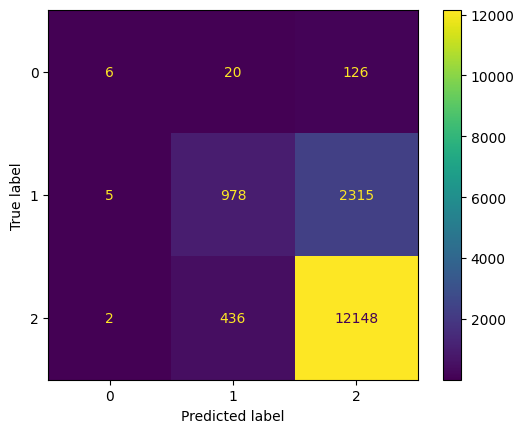




On Val: 
109/109 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.27      0.14      0.19       702
           2       0.80      0.90      0.85      2725

    accuracy                           0.74      3459
   macro avg       0.36      0.35      0.34      3459
weighted avg       0.68      0.74      0.70      3459



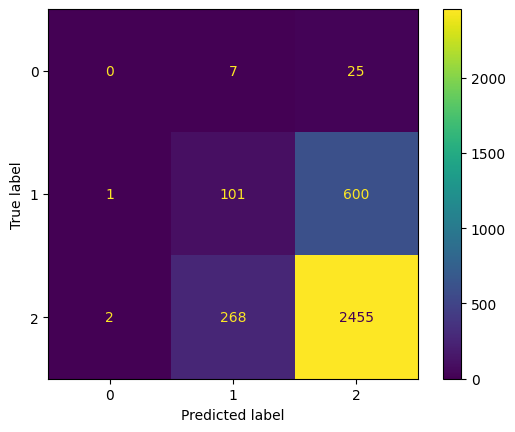




On Test: 
109/109 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.26      0.13      0.17       727
           2       0.79      0.90      0.84      2700

    accuracy                           0.73      3460
   macro avg       0.35      0.34      0.34      3460
weighted avg       0.67      0.73      0.69      3460



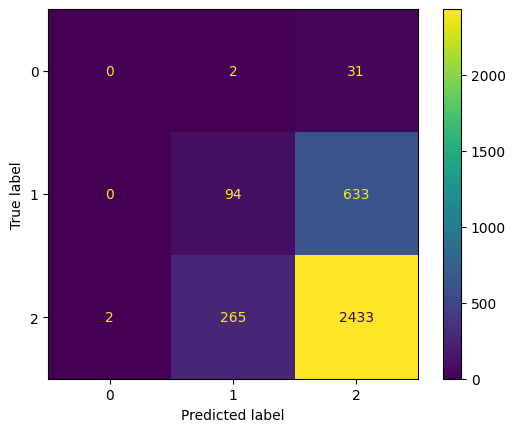

In [42]:
print("On Train: ")
y_pred_probabilities = model2.predict(sequences_padded_train)
y_pred = np.argmax(y_pred_probabilities, axis=1)
get_metrics(y_train, y_pred, "train")

print("On Val: ")
y_pred_probabilities = model2.predict(sequences_padded_val)
y_pred = np.argmax(y_pred_probabilities, axis=1)
get_metrics(y_val, y_pred, "val")

print("On Test: ")
y_pred_probabilities = model2.predict(sequences_padded_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)
get_metrics(y_test, y_pred, "test")